In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load and parse date
df = pd.read_csv("airport_traffic_2024.csv")
df['FLT_DATE'] = pd.to_datetime(df['FLT_DATE'], format='%d-%m-%y')

# Fill missing IFR values with 0
ifr_cols = ['FLT_DEP_IFR_2', 'FLT_ARR_IFR_2', 'FLT_TOT_IFR_2']
df[ifr_cols] = df[ifr_cols].fillna(0)

# Sort data to ensure correct lagging
df = df.sort_values(by=['APT_ICAO', 'FLT_DATE']).reset_index(drop=True)

# ======================
# 📅 Time-based Features
# ======================
df['day'] = df['FLT_DATE'].dt.day
df['month'] = df['FLT_DATE'].dt.month
df['weekday'] = df['FLT_DATE'].dt.weekday
df['dayofyear'] = df['FLT_DATE'].dt.dayofyear
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['is_peak_season'] = df['month'].isin([6, 7, 8, 12]).astype(int)

# ====================
# 🔁 Lag & Rolling Features
# ====================
group = df.groupby('APT_ICAO')

# Lag features
df['lag_1'] = group['FLT_TOT_1'].shift(1)
df['lag_2'] = group['FLT_TOT_1'].shift(2)
df['lag_7'] = group['FLT_TOT_1'].shift(7)

# Rolling means
df['roll_mean_3'] = group['FLT_TOT_1'].transform(lambda x: x.shift(1).rolling(3).mean())
df['roll_mean_7'] = group['FLT_TOT_1'].transform(lambda x: x.shift(1).rolling(7).mean())

# Drop rows with NaNs introduced by shifting
df.dropna(inplace=True)

feature_cols = [
    'FLT_DEP_1', 'FLT_ARR_1', 'FLT_TOT_1',
    'FLT_DEP_IFR_2', 'FLT_ARR_IFR_2', 'FLT_TOT_IFR_2',
    'day', 'month', 'weekday', 'dayofyear',
    'is_weekend', 'is_peak_season',
    'lag_1', 'lag_2', 'lag_7', 'roll_mean_3', 'roll_mean_7'
]

# ✅ Final dataset is ready for model input
print("✅ Preprocessing complete. Sample:")
print(df[feature_cols + ['FLT_DATE', 'APT_ICAO']].head())


✅ Preprocessing complete. Sample:
    FLT_DEP_1  FLT_ARR_1  FLT_TOT_1  FLT_DEP_IFR_2  FLT_ARR_IFR_2  \
7          74         69        143            0.0            0.0   
8          61         71        132            0.0            0.0   
9          67         72        139            0.0            0.0   
10         74         70        144            0.0            0.0   
11         73         65        138            0.0            0.0   

    FLT_TOT_IFR_2  day  month  weekday  dayofyear  is_weekend  is_peak_season  \
7             0.0    8      1        0          8           0               0   
8             0.0    9      1        1          9           0               0   
9             0.0   10      1        2         10           0               0   
10            0.0   11      1        3         11           0               0   
11            0.0   12      1        4         12           0               0   

    lag_1  lag_2  lag_7  roll_mean_3  roll_mean_7   FLT_DATE APT

🔍 Checking missing values...
YEAR              0
MONTH_NUM         0
MONTH_MON         0
FLT_DATE          0
APT_ICAO          0
APT_NAME          0
STATE_NAME        0
FLT_DEP_1         0
FLT_ARR_1         0
FLT_TOT_1         0
FLT_DEP_IFR_2     0
FLT_ARR_IFR_2     0
FLT_TOT_IFR_2     0
day               0
month             0
weekday           0
dayofyear         0
is_weekend        0
is_peak_season    0
lag_1             0
lag_2             0
lag_7             0
roll_mean_3       0
roll_mean_7       0
dtype: int64

📊 Correlation matrix:

📈 Correlation with FLT_TOT_1:
FLT_TOT_1         1.000000
FLT_ARR_1         0.999883
FLT_DEP_1         0.999883
lag_7             0.996429
roll_mean_7       0.995219
roll_mean_3       0.993584
lag_1             0.992314
lag_2             0.989560
FLT_TOT_IFR_2     0.937144
FLT_DEP_IFR_2     0.937062
FLT_ARR_IFR_2     0.937025
is_peak_season    0.033438
month             0.023473
MONTH_NUM         0.023473
dayofyear         0.023088
weekday           0

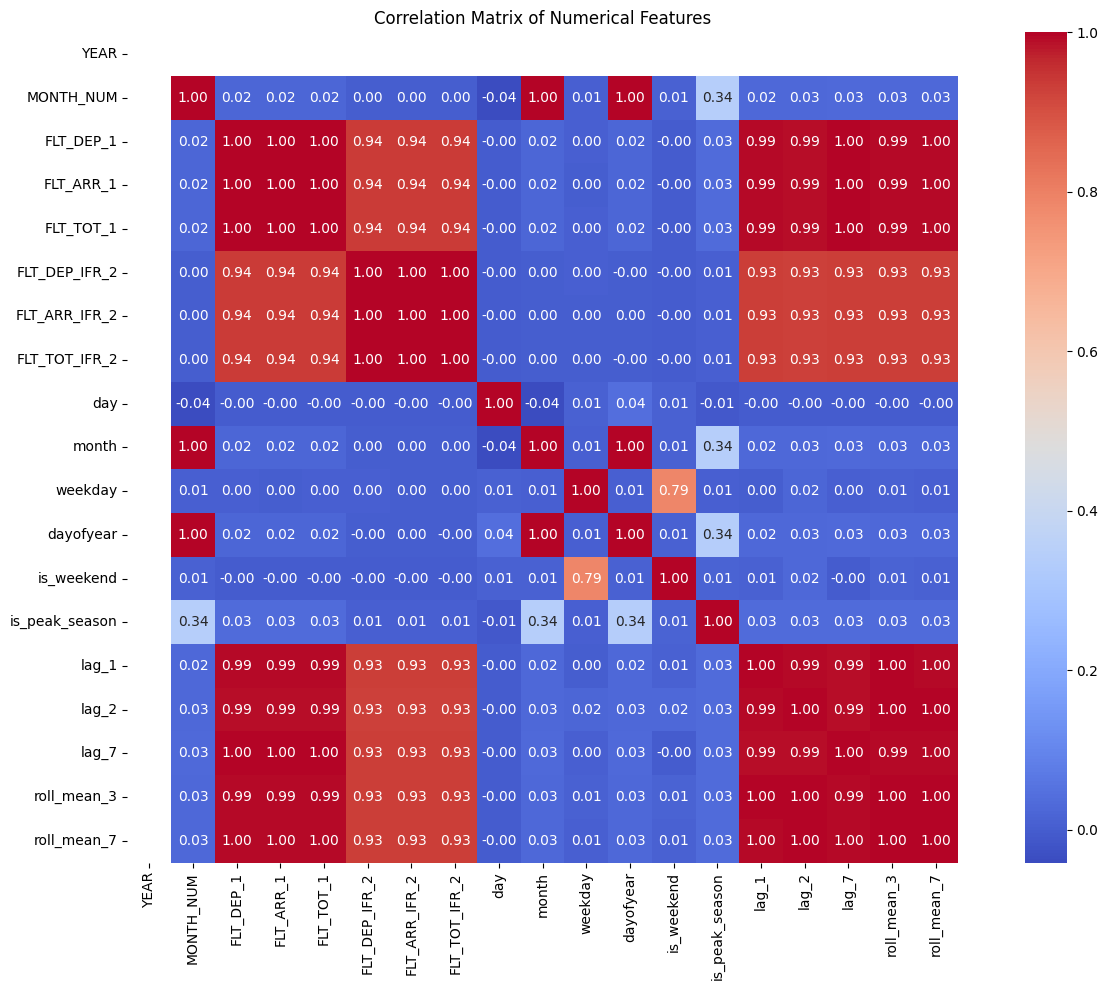

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Check for missing values
print("🔍 Checking missing values...")
missing_values = df.isnull().sum()
print(missing_values)

# Step 2: Correlation matrix for numerical features
print("\n📊 Correlation matrix:")
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numerical_cols].corr()

# Step 3: Correlation with target variable FLT_TOT_1
print("\n📈 Correlation with FLT_TOT_1:")
print(correlation_matrix['FLT_TOT_1'].sort_values(ascending=False))

# Step 4: Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()


In [11]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Drop unused identifier/date columns
df_model = df.drop(columns=['FLT_DATE', 'YEAR', 'MONTH_MON', 'APT_NAME', 'APT_ICAO', 'STATE_NAME'], errors='ignore')

# Ensure all remaining columns are numeric
df_model = df_model.select_dtypes(include=[np.number])

# Fill NaNs with 0 if any remain
df_model = df_model.fillna(0)

# Separate features and target
target_variable = 'FLT_TOT_1'
X_all = df_model.drop(columns=[target_variable])
y_all = df_model[[target_variable]]  # ← keep as 2D array for scaler

# Standardize features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_all)

# Standardize target
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_all)

# Convert to numpy arrays
X_np = X_scaled.astype(np.float32)
y_np = y_scaled.astype(np.float32).flatten()

# Create sequences (same as before)
def create_sequences(X, y, seq_length=30):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i + seq_length])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_np, y_np, seq_length=30)

# 60/20/20 split (same)
n = len(X_seq)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train = X_seq[:train_end]
y_train = y_seq[:train_end]
X_val = X_seq[train_end:val_end]
y_val = y_seq[train_end:val_end]
X_test = X_seq[val_end:]
y_test = y_seq[val_end:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(f"✅ Train: X={X_train_tensor.shape}, y={y_train_tensor.shape}")
print(f"✅ Val:   X={X_val_tensor.shape}, y={y_val_tensor.shape}")
print(f"✅ Test:  X={X_test_tensor.shape}, y={y_test_tensor.shape}")


✅ Train: X=torch.Size([67447, 30, 17]), y=torch.Size([67447])
✅ Val:   X=torch.Size([22483, 30, 17]), y=torch.Size([22483])
✅ Test:  X=torch.Size([22483, 30, 17]), y=torch.Size([22483])


In [4]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # last timestep output
        return self.fc(out).squeeze()

input_dim = X_train_tensor.shape[2]
model = LSTMRegressor(input_dim=input_dim)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


✅ Using device: cuda


In [6]:
# Move model
model = model.to(device)

# Move data tensors
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


In [7]:
epochs = 50
batch_size = 256
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size(0))
    epoch_loss = 0

    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_X = X_train_tensor[indices].to(device)
        batch_y = y_train_tensor[indices].to(device)

        optimizer.zero_grad()
        output = model(batch_X)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_loss = epoch_loss / (len(X_train_tensor) // batch_size)

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val_tensor)
        val_loss = loss_fn(val_output, y_val_tensor).item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}", flush=True)


Epoch 1/50 | Train Loss: 0.0809 | Val Loss: 0.0131
Epoch 2/50 | Train Loss: 0.0222 | Val Loss: 0.0107
Epoch 3/50 | Train Loss: 0.0201 | Val Loss: 0.0098
Epoch 4/50 | Train Loss: 0.0182 | Val Loss: 0.0089
Epoch 5/50 | Train Loss: 0.0171 | Val Loss: 0.0094
Epoch 6/50 | Train Loss: 0.0161 | Val Loss: 0.0089
Epoch 7/50 | Train Loss: 0.0155 | Val Loss: 0.0085
Epoch 8/50 | Train Loss: 0.0150 | Val Loss: 0.0094
Epoch 9/50 | Train Loss: 0.0144 | Val Loss: 0.0082
Epoch 10/50 | Train Loss: 0.0141 | Val Loss: 0.0078
Epoch 11/50 | Train Loss: 0.0143 | Val Loss: 0.0077
Epoch 12/50 | Train Loss: 0.0136 | Val Loss: 0.0097
Epoch 13/50 | Train Loss: 0.0135 | Val Loss: 0.0075
Epoch 14/50 | Train Loss: 0.0133 | Val Loss: 0.0071
Epoch 15/50 | Train Loss: 0.0132 | Val Loss: 0.0077
Epoch 16/50 | Train Loss: 0.0132 | Val Loss: 0.0080
Epoch 17/50 | Train Loss: 0.0128 | Val Loss: 0.0072
Epoch 18/50 | Train Loss: 0.0128 | Val Loss: 0.0069
Epoch 19/50 | Train Loss: 0.0124 | Val Loss: 0.0066
Epoch 20/50 | Train L

C:\Users\Ong\AppData\Local\Temp\ipykernel_195132\3697337399.py:20: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Ong\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


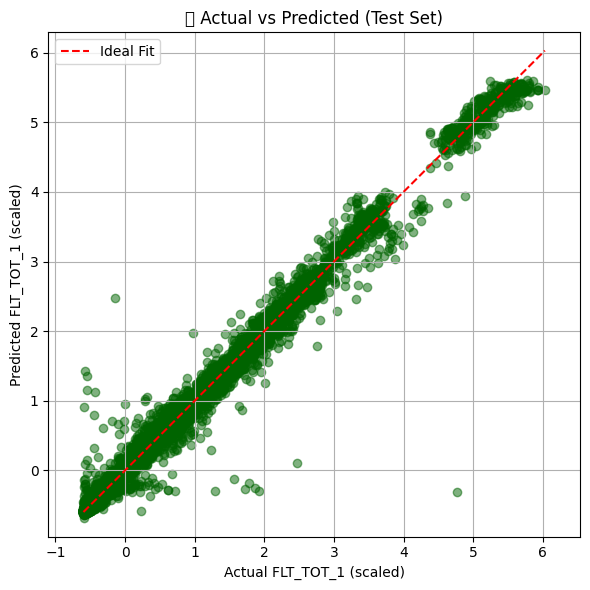

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

# Plot actual vs predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5, color='darkgreen')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal Fit')
plt.xlabel("Actual FLT_TOT_1 (scaled)")
plt.ylabel("Predicted FLT_TOT_1 (scaled)")
plt.title("🎯 Actual vs Predicted (Test Set)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Ong\AppData\Local\Temp\ipykernel_195132\1384005783.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Ong\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


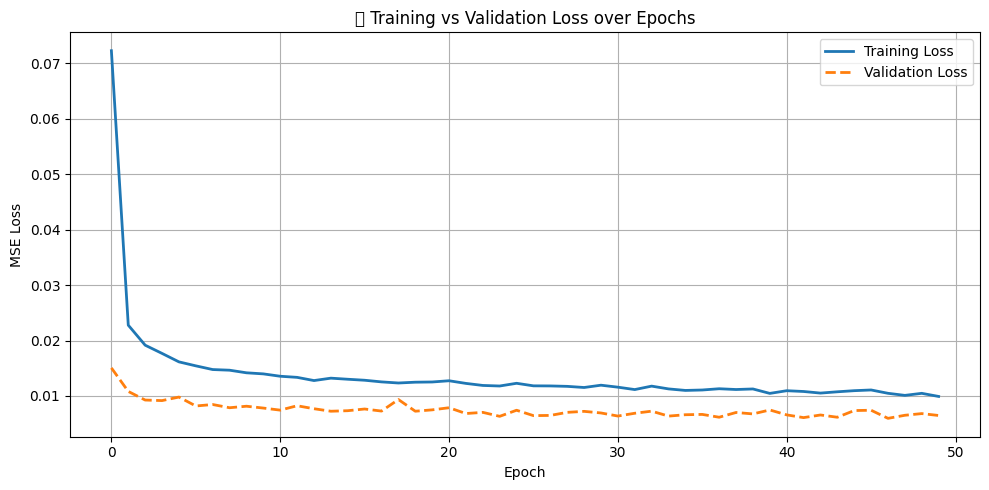

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2, linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(" Training vs Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 🔹 Predict on scaled test data
model.eval()
with torch.no_grad():
    y_pred_test_scaled = model(X_test_tensor.to(device)).cpu().numpy()
    y_true_test_scaled = y_test_tensor.cpu().numpy()

# 🔹 Compute metrics
mse_scaled = mean_squared_error(y_true_test_scaled, y_pred_test_scaled)
rmse_scaled = np.sqrt(mse_scaled)
mae_scaled = mean_absolute_error(y_true_test_scaled, y_pred_test_scaled)
r2_scaled = r2_score(y_true_test_scaled, y_pred_test_scaled)

# 🔹 Print results
print(" Scaled Test Set Evaluation:")
print(f"🔹 RMSE: {rmse_scaled:.4f}")
print(f"🔹 MAE:  {mae_scaled:.4f}")
print(f"🔹 R²:   {r2_scaled:.4f}")


📊 Scaled Test Set Evaluation:
🔹 RMSE: 0.0972
🔹 MAE:  0.0476
🔹 R²:   0.9920


<ipython-input-29-f110197bb048>:10: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


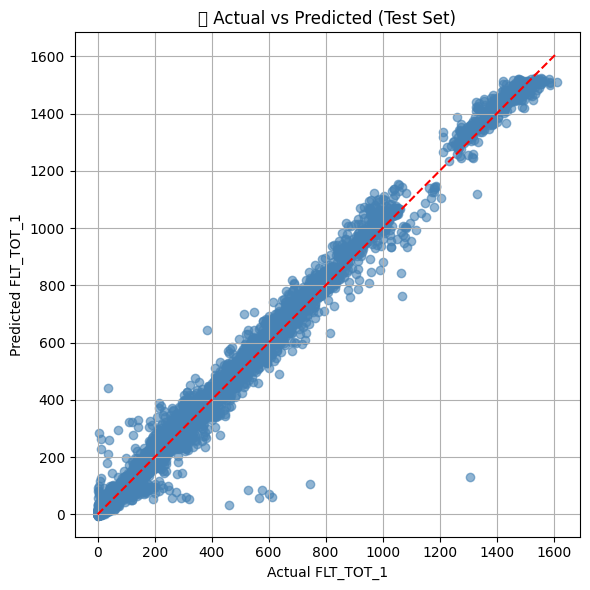

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true_denorm, y_pred_denorm, alpha=0.6, color='steelblue')
plt.plot([y_true_denorm.min(), y_true_denorm.max()],
         [y_true_denorm.min(), y_true_denorm.max()], 'r--')
plt.title("🎯 Actual vs Predicted (Test Set)")
plt.xlabel("Actual FLT_TOT_1")
plt.ylabel("Predicted FLT_TOT_1")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [20]:
import torch
from torch import nn
import itertools
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define your LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out).squeeze()

# 🧪 Your data (replace with actual preprocessed tensors)
# X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor must be available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

input_dim = X_train_tensor.shape[2]
batch_size = 256
epochs = 30

# Hyperparameter grid
param_grid = {
    'hidden_dim': [64, 128],
    'num_layers': [3],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [1e-4, 5e-4, 1e-3, 5e-3]
}
grid = list(itertools.product(*param_grid.values()))

best_val_mse = float('inf')
best_train_losses = []
best_val_losses = []
best_config = {}

for hidden_dim, num_layers, dropout, lr in grid:
    model = LSTMRegressor(input_dim, hidden_dim, num_layers, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train_tensor.size(0))
        epoch_loss = 0
        for i in range(0, X_train_tensor.size(0), batch_size):
            idx = permutation[i:i+batch_size]
            xb, yb = X_train_tensor[idx], y_train_tensor[idx]
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss = epoch_loss / (len(X_train_tensor) // batch_size)

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = loss_fn(val_pred, y_val_tensor).item()
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # Final validation MSE
    model.eval()
    with torch.no_grad():
        final_pred = model(X_val_tensor).cpu().numpy()
        final_true = y_val_tensor.cpu().numpy()
        val_mse = mean_squared_error(final_true, final_pred)

    print(f"[{hidden_dim=}, {num_layers=}, {dropout=}, {lr=}] → val_mse={val_mse:.4f}")

    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_train_losses = train_losses
        best_val_losses = val_losses
        best_config = {
            'hidden_dim': hidden_dim,
            'num_layers': num_layers,
            'dropout': dropout,
            'lr': lr
        }

[hidden_dim=64, num_layers=3, dropout=0.1, lr=0.0001] → val_mse=0.0091
[hidden_dim=64, num_layers=3, dropout=0.1, lr=0.0005] → val_mse=0.0068
[hidden_dim=64, num_layers=3, dropout=0.1, lr=0.001] → val_mse=0.0075
[hidden_dim=64, num_layers=3, dropout=0.1, lr=0.005] → val_mse=0.0097
[hidden_dim=64, num_layers=3, dropout=0.2, lr=0.0001] → val_mse=0.0097
[hidden_dim=64, num_layers=3, dropout=0.2, lr=0.0005] → val_mse=0.0074
[hidden_dim=64, num_layers=3, dropout=0.2, lr=0.001] → val_mse=0.0067
[hidden_dim=64, num_layers=3, dropout=0.2, lr=0.005] → val_mse=0.0075
[hidden_dim=64, num_layers=3, dropout=0.3, lr=0.0001] → val_mse=0.0097
[hidden_dim=64, num_layers=3, dropout=0.3, lr=0.0005] → val_mse=0.0074
[hidden_dim=64, num_layers=3, dropout=0.3, lr=0.001] → val_mse=0.0072
[hidden_dim=64, num_layers=3, dropout=0.3, lr=0.005] → val_mse=0.0084
[hidden_dim=128, num_layers=3, dropout=0.1, lr=0.0001] → val_mse=0.0080
[hidden_dim=128, num_layers=3, dropout=0.1, lr=0.0005] → val_mse=0.0063
[hidden_di

In [21]:
# Save model weights + hyperparameters
torch.save({
    'model_state_dict': model.state_dict(),
    'config': best_config
}, 'lstm_model_with_config.pth')


In [23]:
best_model_state = model.state_dict()

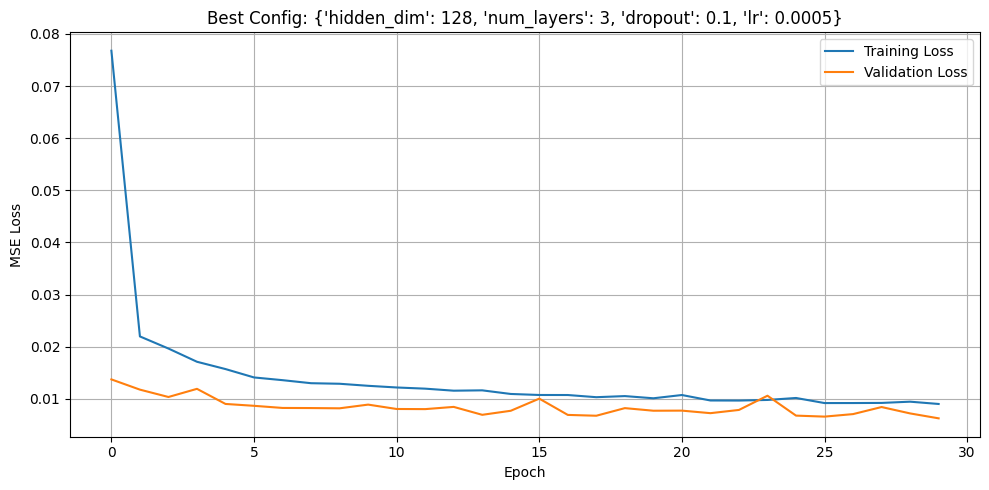

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Training Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Best Config: {best_config}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# ✅ Recreate and load best model
best_model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=best_config['hidden_dim'],
    num_layers=best_config['num_layers'],
    dropout=best_config['dropout']
).to(device)
best_model.load_state_dict(best_model_state)
best_model.eval()


LSTMRegressor(
  (lstm): LSTM(17, 128, num_layers=3, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [14]:
with torch.no_grad():
    y_pred = model(X_val_tensor).cpu().numpy()
    y_true = y_val_tensor.cpu().numpy()
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))


MSE: 0.007371281739324331
RMSE: 0.08585616890663321
MAE: 0.04351413995027542


 Best Model Evaluation (Scaled):
🔹 RMSE: 0.0946
🔹 MAE:  0.0413
🔹 R²:   0.9873


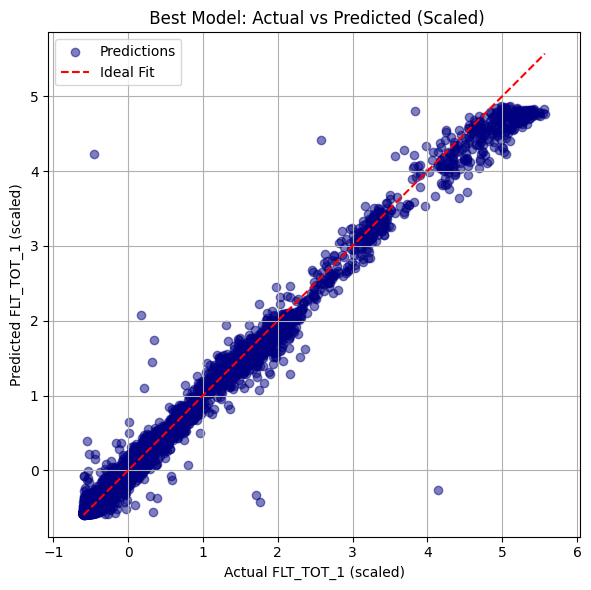

In [27]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 📦 Evaluate best model
best_model.eval()
with torch.no_grad():
    y_pred = best_model(X_val_tensor.to(device)).cpu().numpy()
    y_true = y_val_tensor.cpu().numpy()

#  Metrics (scaled)
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(" Best Model Evaluation (Scaled):")
print(f"🔹 RMSE: {rmse:.4f}")
print(f"🔹 MAE:  {mae:.4f}")
print(f"🔹 R²:   {r2:.4f}")

# 📈 Plot actual vs predicted (scaled)
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5, color='navy', label='Predictions')
plt.plot([min(y_true), max(y_true)],
         [min(y_true), max(y_true)], 'r--', label='Ideal Fit')
plt.xlabel("Actual FLT_TOT_1 (scaled)")
plt.ylabel("Predicted FLT_TOT_1 (scaled)")
plt.title(" Best Model: Actual vs Predicted (Scaled)")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()


📊 Best Model Evaluation:
🔹 MSE:  436.18
🔹 RMSE: 20.89
🔹 MAE:  10.59


C:\Users\Ong\AppData\Local\Temp\ipykernel_153940\1749168040.py:42: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Ong\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


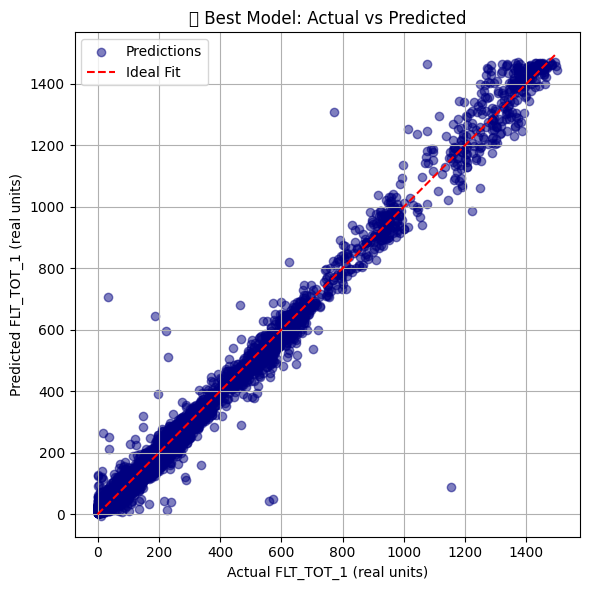

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# 📦 Evaluate best model
best_model.eval()
with torch.no_grad():
    y_pred_scaled = best_model(X_val_tensor).cpu().numpy()
    y_true_scaled = y_val_tensor.cpu().numpy()

# 🔁 Optional: Denormalize if target was scaled
if 'scaler_y' in globals():
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = scaler_y.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()
    label = "FLT_TOT_1 (real units)"
else:
    y_pred = y_pred_scaled
    y_true = y_true_scaled
    label = "FLT_TOT_1 (scaled)"

# 📊 Metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("📊 Best Model Evaluation:")
print(f"🔹 MSE:  {mse:.2f}")
print(f"🔹 RMSE: {rmse:.2f}")
print(f"🔹 MAE:  {mae:.2f}")

# 📈 Plot actual vs predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5, color='navy', label='Predictions')
plt.plot([min(y_true), max(y_true)],
         [min(y_true), max(y_true)], 'r--', label='Ideal Fit')
plt.xlabel(f"Actual {label}")
plt.ylabel(f"Predicted {label}")
plt.title("🎯 Best Model: Actual vs Predicted")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
torch.save(best_model.state_dict(), "lstm_model.pth")
